In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
values = {}

17640
17640


/Users/briancruz/repos/research/music_299_2025sp/audio_utils.py:25: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _sr, plate = wavfile.read(download_url(url))


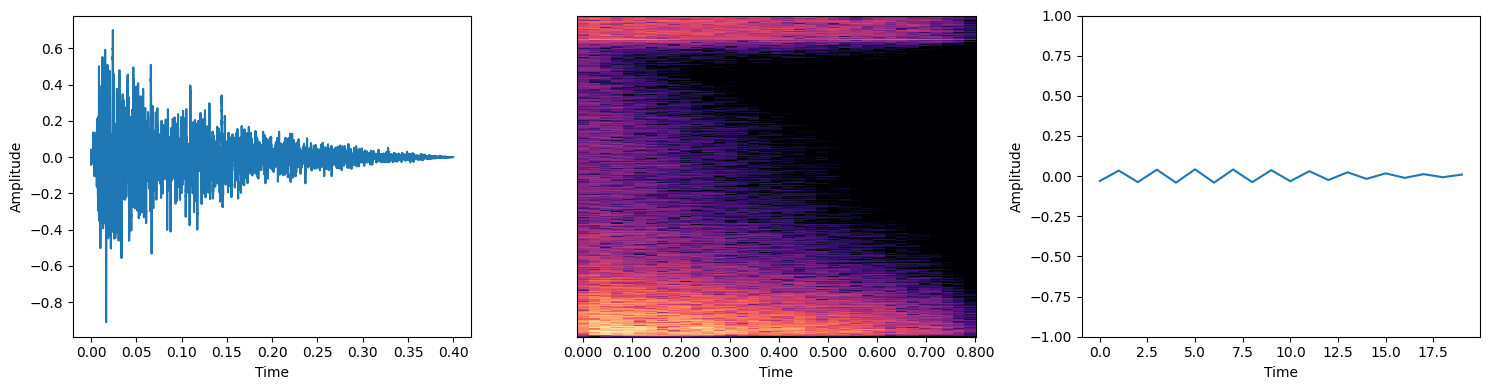

In [8]:
from audio_utils import get_stereo_impulse_response, play_audio

plate_left, plate_right = get_stereo_impulse_response(
    **{
        "start_seconds": 0.000,
        "length_seconds": 0.4,
        "fade_in_seconds": 0.000,
        "fade_out_seconds": 0.4,
        "url": "https://oramics.github.io/sampled/IR/EMT140-Plate/samples/emt_140_dark_1.wav",
        # "dry_wet_balance": 1.0,
    }
)

print(len(plate_left))

# write_wave("knock.wav", plate_left)
print(len(plate_left))
play_audio(plate_left, auto_play=True)


In [9]:
import sympy as sy

from modal_piano import BiQuad, FiniteImpulseResponse, InfiniteImpulseResponse

coeffs = (
    1.0,
    2.0,
    3.0,
    4.0,
)

fir = FiniteImpulseResponse(response=coeffs)

assert fir.get_z_transform() - sy.sympify("1.0 + 2.0/z + 3.0/z**2 + 4.0/z**3") == 0

f = InfiniteImpulseResponse(b=(1, 2, 3), a=(1, 0.0, 0.5))

f.show_transfer_function()

assert f.as_faust_iir() == "(fi.iir((1.0,2.0,3.0),(0.0,0.5))"

bq = BiQuad(b=(1, 2, 3), a=(1, 0.0, 0.5))


bq.show_transfer_function()

assert bq.as_faust_iir() == "(fi.iir((1.0,2.0,3.0),(0.0,0.5))"

assert bq._fir_numerator.as_faust_fir() == "(fi.fir((1.0,2.0,3.0))"

assert bq.as_faust_tf21() == "(fi.tf21(1.0,2.0,3.0,0.0,0.5))"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
import jinja2
import matplotlib.pyplot as plt
import numpy as np

from audio_utils import AudioClip, add_silence
from modal_piano import Resonator
from pyfaust import FaustProcessor

x_h = 0.1
B = 0.001
b_0 = 1e-5
f_0 = 220.0
# Create a list of 10 resonators for harmonics of 440 Hz (square wave has odd harmonics)
resonators = [
    Resonator(
        f_k=(f_k := f_0 * harmonic * np.sqrt(1 + B * harmonic**2)),
        tau=1.0 / (0.5 + 1.58e-10 * f_k**2 / f_0**2 + b_0 * f_0**2),
        A=10 * 1.0 / harmonic * np.sin(np.pi * harmonic * x_h),
    )
    for harmonic in range(1, 10)
]
resonators[0]

Resonator(f_k=220.109972513741, tau=1.01626016243828, A=3.09016994374947)

/Users/briancruz/repos/research/music_299_2025sp/.venv/lib/python3.12/site-packages/cffi/vengine_cpy.py:192: UserWarning: reimporting '_cffi__x8b3fe5b1xfdf1f84' might overwrite older definitions
  warnings.warn("reimporting %r might overwrite older definitions"
Exception ignored from callback for ffi.gc <cdata 'mydsp *' 0x128100000>:
Traceback (most recent call last):
  File "/var/folders/zk/5c2c39w140d2jm1q_p1lzdr00000gn/T/ipykernel_51769/3832282511.py", line 76, in <module>
TypeError: initializer for ctype 'mydsp *' appears indeed to be 'mydsp *', but the types are different (check that you are not e.g. mixing up different ffi instances)


Listing b_ and p_ parameters:
fp.dsp.dsp
fp.dsp.dsp.b_external_force
fp.dsp.dsp.b_external_force.p_play


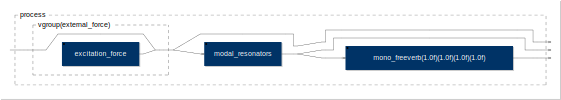

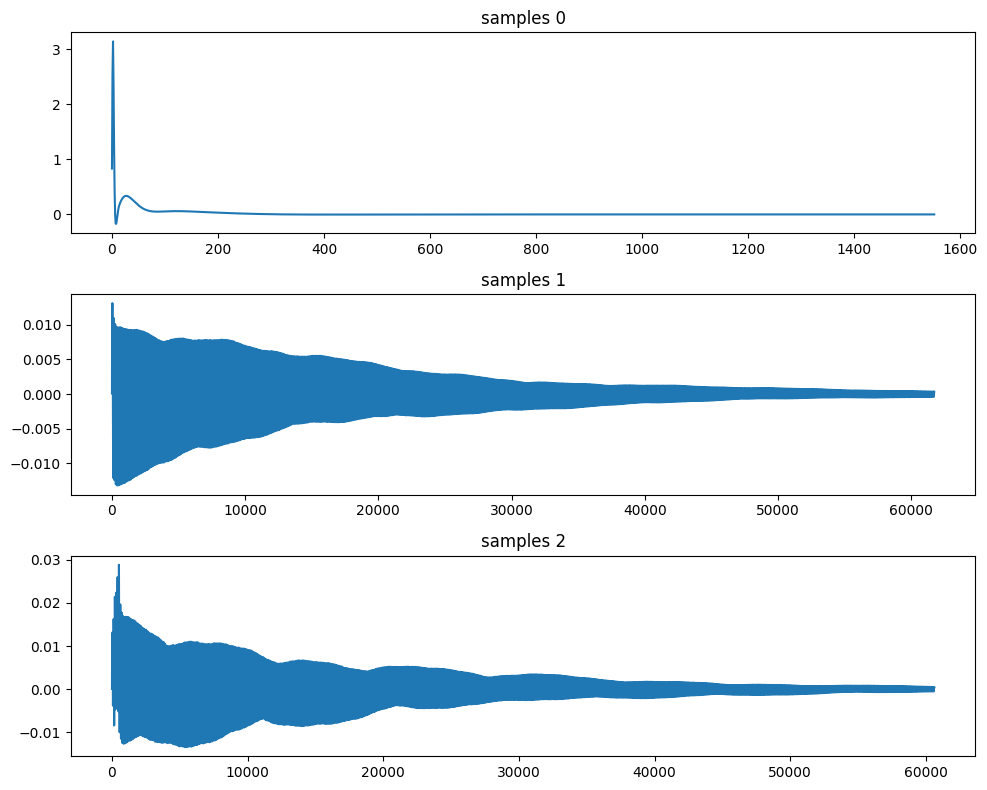

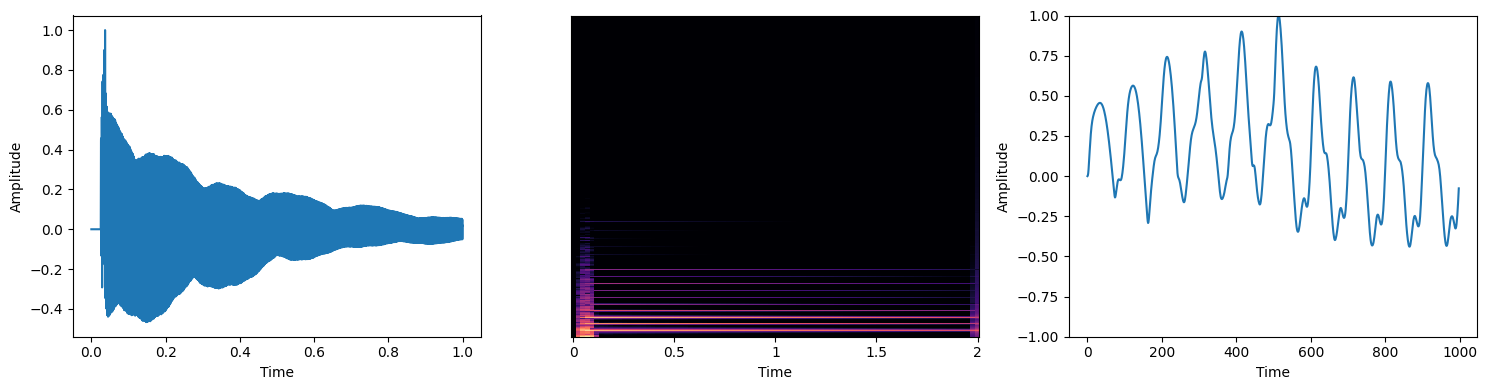

In [11]:
import numpy as np
from scipy import integrate

from modal_piano import Resonator

x_h = 0.16
B = 0.001
b_0 = 1e-5
f_0 = 110.0 * 4
# Create a list of 10 resonators for harmonics of 440 Hz (square wave has odd harmonics)
resonators = [
    Resonator(
        f_k=(f_k := f_0 * harmonic * np.sqrt(1 + B * harmonic**2)),
        tau=1.0 / (0.5 + 1.58e-10 * f_k**2 / f_0**2 + b_0 * f_0**2),
        A=1.0
        * harmonic**-3.1
        * integrate.quad(
            lambda x: np.sin(np.pi * harmonic * x), x_h - 0.02, x_h + 0.02
        )[0]
        / 0.02
        / 0.02,
    )
    for harmonic in range(1, 100)
]

# remove resonators with resonant frequency above the Nyquist frequency
resonators = [res for res in resonators if res.estimate_resonant_frequency() < 22050]


# Generate Faust code using Jinja template
template = """
import("stdfaust.lib");

modal_resonators = _ <:({% for res in resonators %}
    // Resonator {{ loop.index }}: {{ res.estimate_resonant_frequency() }} Hz
    {{ res.as_faust_tf21t() }}
    {% if not loop.last %},{% endif %}
{% endfor %}) :> _;

positive = \\(x).(x * (x > 0.0));

excitation_force = (
    button("play")
    : ba.impulsify
    <: (fi.lowpass(2, 5000), (fi.lowpass(2, 500) : de.delay(100,10)),  (fi.lowpass(2, 100) : de.delay(200,20)))
    :> *(10)
);

body_res = _;

// Modal resonator bank for parallel processing
process = 
_
: vgroup("external_force", _ <: _, excitation_force :> _ : body_res : _)
<: (
    si.bus(1),
    modal_resonators
)
: route(2, 3, 1, 1, 2, 2, 2, 3)
: (
    _,
    _,
    (body_res : re.mono_freeverb(1.0, 1.0, 1.0, 1.0))
)

;
"""


env = jinja2.Environment()
template_obj = env.from_string(template)
code = template_obj.render(
    resonators=resonators, **{str(k): v for k, v in values.items()}
)

with FaustProcessor(code) as fp:
    fp.show_components()
    fp.show_signal_graph()

    fp.dsp.dsp.b_external_force.p_play.zone = 1
    # fp.dsp.dsp.b_my_faust.b_hammer.p_play.zone = 1

    # out = fp.compute(plate_left.astype(np.float32))
    # out = fp.compute(impulse(2.0).astype(np.float32) * 0.0)
    out = fp.compute(add_silence(plate_left.astype(np.float32), 1) * 0.0)

    # Graph traces and output
    N = len(out.samples)
    fig, axs = plt.subplots(N, 1, figsize=(10, 8))

    for i in range(N):
        show_samples = out.samples[i]
        # Remove silence at the beginning and end
        show_samples = show_samples[
            np.where(show_samples > 1e-8)[0][0] : np.where(show_samples > 1e-8)[0][-1]
        ]
        axs[i].plot(show_samples)
        axs[i].set_title(f"samples {i}")

    plt.tight_layout()
    plt.show()

    # Play the output
    out_fb = out.samples[2]
    # out_fb = convolve(out_fb, plate_left, mode="full")
    out_fb = out_fb / np.max(np.abs(out_fb))

    AudioClip(out_fb).play(normalize=True)


In [12]:
print(code)


import("stdfaust.lib");

modal_resonators = _ <:(
    // Resonator 1: 440.084838867188 Hz
    (fi.tf21t(0.0, 6.842312054016565e-05, 0.0, -1.9959571455641898, 0.9998895299117861))
    ,

    // Resonator 2: 881.515502929688 Hz
    (fi.tf21t(0.0, 2.7903570814807592e-05, 0.0, -1.9841284330212747, 0.9998895299117646))
    ,

    // Resonator 3: 1325.63781738281 Hz
    (fi.tf21t(0.0, 1.4018559700349464e-05, 0.0, -1.9643095531743409, 0.9998895299117284))
    ,

    // Resonator 4: 1773.79760742188 Hz
    (fi.tf21t(0.0, 6.905609626248294e-06, 0.0, -1.9363470279773323, 0.9998895299116769))
    ,

    // Resonator 5: 2227.34069824219 Hz
    (fi.tf21t(0.0, 2.7860798956866954e-06, 0.0, -1.9000321646085234, 0.9998895299116098))
    ,

    // Resonator 6: 2687.61291503906 Hz
    (fi.tf21t(0.0, 4.0120099599641147e-07, 0.0, -1.8551073587875286, 0.9998895299115261))
    ,

    // Resonator 7: 3154.61425781250 Hz
    (fi.tf21t(0.0, -8.425455541072558e-07, 0.0, -1.8012743722014548, 0.9998895299114251))